# Recognising Goodreads ratings - Artificial Intelligence project
Daniela Stern-Gabsi
# Inference- Goodreads Genres

We will try to recognise the books genres using different types of models:

    1. Baseline model- simple rule based model. Based on the author former book genre.
    2. Logistic regression
    3. Random forest
    4. Support vector machine
    5. Convolutional neural network- based on images of book covers
    6. Neural network based on embeddings

Our metrics will be : Accuracy and F1 weighted average. 
Accuracy is a simple metric calculating the precentages of values predicted correctly.

The F1 score takes into  account  both  precision  and  recall  values. 

$$ accuracy = \frac{TP+TN}{TP+FP+TN+FN} $$


$$ precision = \frac{TP}{TP+FP}$$
$$ recall = \frac{TP}{TP+FN}$$
$$ F1 = \frac{2 * (precision * recall)}{(precision + recall)}$$

In [1]:
#Import necessary packages
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
import goodreads as gr
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler,PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import spacy
import gensim
from gensim.models.word2vec import Word2Vec
import tensorflow as tf


from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /home/neuralx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/neuralx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First we will load the configuration file contaning all needed hyperparameters

In [2]:
#load configuration file
try:
    with open('configuration.yml', 'r') as file:
        conf = yaml.load(file, Loader=yaml.FullLoader)
except Exception as e:
    print('Error reading the config file')

In [3]:
conf

{'files': {'data_dir': 'data',
  'books_file': 'goodreads_books_eng_f.csv',
  'image_source_dir': 'data/images-source',
  'images_list': 'books_images_names.csv'},
 'preprocessed': {'preprocess_col_order': ['book_id',
   'work_id',
   'title',
   'num_pages',
   'publication_year',
   'description',
   'is_ebook',
   'series',
   'image_url',
   'read_count',
   'text_reviews_count',
   'ratings_count',
   'average_rating',
   'author_id',
   'name',
   'public_year_null',
   'num_pages_null',
   'authors_ratings_count',
   'author_average_rating',
   'genre'],
  'genres_col': ['poetry',
   'children',
   'fantasy, paranormal',
   'history, historical fiction, biography',
   'comics, graphic',
   'non-fiction',
   'mystery, thriller, crime',
   'young-adult',
   'romance'],
  'full_genres_col': ['poetry',
   'children',
   'fantasy, paranormal',
   'history, historical fiction, biography',
   'comics, graphic',
   'non-fiction',
   'mystery, thriller, crime',
   'young-adult',
   'roma

In [4]:
#data locations
data_path = os.path.abspath(conf["files"]["data_dir"])
image_source_path = os.path.abspath(conf["files"]["image_source_dir"])
image_source_list = conf["files"]["images_list"]

### Important- set seed

In [5]:
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Important- If you already run the full EDA notebook-you can run only the following line (Or if running second time).
### After running  skip to Models sections

We create a GoodreadsDataset object that will contain an alreday prepared train, validation and tests datasets. We assumed it is already prepared.

In [6]:
goodr_dataset = gr.GoodreadsDataset.load_from_split(conf['preprocessed'], image_source_path, image_source_list, data_path)

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples


### Or -Start from fresh

Loading the dataset. Running preporcessing tasks and splitting the datasets to train, valdation and test set.
This can take a while since it prepares both data and images folders

In [7]:
test_pct = conf["test_precentage"]
val_pct = conf["val_precentage"]

In [8]:
print(f"Test precentage (From total dataset) : {test_pct}")
print(f"Validation precentage (From train dataset): {val_pct}")

Test precentage (From total dataset) : 0.1
Validation precentage (From train dataset): 0.1


In [9]:
books_file = os.path.join(conf["files"]["data_dir"], conf["files"]["books_file"])
books = pd.read_csv(books_file, na_values=['NA', ''])

goodr_dataset=gr.GoodreadsDataset(conf['preprocessed'], image_source_path,image_source_list,data_path)
goodr_dataset.preprocess(books)

#This can take a while since it prepares images folders
goodr_dataset.prepare_train_test_split(test_pct=test_pct, val_pct=val_pct, seed=SEED)

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples
dataset path  /home/neuralx/PycharmProjects/701project/data/images-train
dataset path  /home/neuralx/PycharmProjects/701project/data/images-val
dataset path  /home/neuralx/PycharmProjects/701project/data/images-test
All images prepared in folders
Dataset splits saved as pickle files


# Models

We will create a dictinary to collect all model results

In [7]:
score_dictionary={'model':[], 'accuracy':[], 'F1-weighted':[] }
full_generes=conf["preprocessed"]["full_genres_col"]

## Baseline model
Our baseline model will be a simple model the determines a the book genre by simply looking for another book written by the same author and if found returns its genre.In case there is no former book it assign the genre as the mode genre.

In [8]:
baseline_learner=gr.Baseline(conf["preprocessed"]["preprocess_col_order"])
baseline_learner.fit(goodr_dataset.X_train, goodr_dataset.y_train)
y_val_predicted=baseline_learner.predict(goodr_dataset.X_val)

Evaluate the model

In [9]:
accuracy=accuracy_score(goodr_dataset.y_val, y_val_predicted)
f1_weighted=f1_score(goodr_dataset.y_val, y_val_predicted, average='weighted')

score_dictionary['model'].append("Baseline")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

print(classification_report(goodr_dataset.y_val, y_val_predicted, labels=conf["preprocessed"]["full_genres_col"]))


                                        precision    recall  f1-score   support

                                poetry       0.68      0.33      0.44       457
                              children       0.70      0.46      0.56       782
                   fantasy, paranormal       0.32      0.82      0.46      2640
history, historical fiction, biography       0.63      0.37      0.46      1920
                       comics, graphic       0.92      0.75      0.83      1036
                           non-fiction       0.65      0.25      0.36      1543
              mystery, thriller, crime       0.75      0.54      0.63      1962
                           young-adult       0.59      0.39      0.47       693
                               romance       0.77      0.61      0.68      2014
                               fiction       0.35      0.16      0.22       665

                              accuracy                           0.52     13712
                             macro avg

In [10]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.524796,0.528185


We can see that our baseline model has achieved: 0.53% accuracy and 0.53% weighted F1.
We can see a high of 0.8 in recall of genre "fantasy, paranormal". This is expected since it was the genre mode and therefore the default prediction of the baseline model. The precision value is low. 
High values of f1 (and both precision and recall) are also seen in the "comics" genre.This might be becuase of repetition of same authors in this category.

### Preparing data for inference

- Numerical features-publication year and ratings features were normalized by using min-max normalization since they have a definite range of values (1500-2020 and 1-5 respectively).Other numerical values were normalized using power transformer box-cox method. We have used this method instead of the popular standard scaler since our features contain strong outlier.Box-Cox is very suitable for features having outliers.It can be used  only for positive values (which is our case).The normalized data will have zero-mean and unit-variance.

- Title and description text features have been transformed in two different methods(that will be used in different models). The first is creating bag of words counts.(we limited to 500 distinct words) and the second method is tfidf normalization.

In [11]:
goodr_dataset.prepare_data_for_inference(add_text_features=True, descr_maxwords=conf["hyperparams"]["desc_maxwords"], title_maxwords=conf["hyperparams"]["title_maxwords"], drop_ids=True, drop_author_id=True,target_hot_encoding=False)


All datasets prepared for inference


We will now take the prepared train,validation and test datasets

In [12]:
X_train=goodr_dataset.X_train.values
X_val=goodr_dataset.X_val.values
X_test=goodr_dataset.X_test.values

In [13]:
y_train=goodr_dataset.y_train
y_val=goodr_dataset.y_val
y_test=goodr_dataset.y_test

In [14]:
column_names=list(goodr_dataset.inference_col_names)

## Naive Bayes'

Bag  of  words  representation  makes  the  assumption  that  simple  counts  of  number  of  words  in  adocument could represent the meaning of the document.  It assumes the order of words does notmatter.According to Bays rule if we know the probability of words in a document given the class(The likelihood) and we know the general probability of a the class(known as the prior) we cancompute the probability of the class given the words in the document.There are no hyperparameters to tune in this case.

Using only bag of words features

In [15]:
bow_text_columns_index=[column_names.index(x) for x in column_names if (x.startswith('bow'))]

In [16]:
full_generes=conf["preprocessed"]["full_genres_col"]

multi_nb = MultinomialNB()
start_time = time.time()
multi_nb.fit(X_train[:,bow_text_columns_index], y_train)
end_time = time.time()
y_val_predicted = multi_nb.predict(X_val[:,bow_text_columns_index])

We can see results are only very slightly better than Baseline

In [17]:
accuracy=accuracy_score(y_val, y_val_predicted)
f1_weighted=f1_score(y_val, y_val_predicted, average='weighted')

In [18]:
score_dictionary['model'].append("Naive bayes'")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [19]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.524796,0.528185
1,Naive bayes',0.554113,0.551830


In [20]:
print(classification_report(goodr_dataset.y_val, y_val_predicted, labels=conf["preprocessed"]["full_genres_col"]))


                                        precision    recall  f1-score   support

                                poetry       0.50      0.62      0.55       457
                              children       0.47      0.48      0.47       782
                   fantasy, paranormal       0.62      0.55      0.58      2640
history, historical fiction, biography       0.52      0.51      0.51      1920
                       comics, graphic       0.49      0.58      0.53      1036
                           non-fiction       0.61      0.62      0.62      1543
              mystery, thriller, crime       0.68      0.60      0.64      1962
                           young-adult       0.35      0.41      0.37       693
                               romance       0.60      0.69      0.64      2014
                               fiction       0.22      0.15      0.18       665

                              accuracy                           0.55     13712
                             macro avg

## Logistic regression

Logistic regression is a classification model which is based on the sigmoid of the linear combination of the features. For this model we will not use our bag of word features. For text features we will use tf-idf normlization.

In [21]:
#we will not use bow columns, we prefer to use tfidf normalization columns
column_names_withoutbow=[x for x in column_names if not (x.startswith('bow'))]

In [22]:
#we will stack train and validation dataset since instead we will use cross validation and grid search.
X_train=goodr_dataset.X_train[column_names_withoutbow].values
X_val = goodr_dataset.X_val[column_names_withoutbow].values

We will search for the best regularization C hyperparameters. C is the inverse of the regularization strength(higher means less regularization).
Since we have multiple classes we will use ‘multinomial’option which uses the cross enthropy loss as the loss function.

In [23]:
C=conf["hyperparams"]["logistic_regre_params"]["C"]

print(f"Different C values we will check are: {C}")

Different C values we will check are: [0.1, 1.0, 10.0, 100.0]


In [24]:
log_r_scores={'C':[], 'accuracy':[], 'f1-weighted':[]}

In [25]:
import time
best_f1_log_r=math.inf
best_log_r_model=None
#Look for the best params. C is the inverse of the regularization strength(higher mean less regularization)
for c in C:
    log_r=LogisticRegression(multi_class="multinomial", C=c, solver="sag" ,max_iter=500, n_jobs=-1,random_state=SEED)
    log_r.fit(X_train, y_train)
    y_val_predicted = log_r.predict(X_val)
    accuracy=accuracy_score(y_val, y_val_predicted)
    f1_weighted=f1_score(y_val, y_val_predicted, average='weighted')
    log_r_scores['C'].append(c)
    log_r_scores['accuracy'].append(accuracy)
    log_r_scores['f1-weighted'].append(f1_weighted)
    if f1_weighted<best_f1_log_r:
            best_f1_log_r=f1_weighted
            best_log_r_model=log_r

In [26]:
df_log_r_scores= pd.DataFrame.from_dict(log_r_scores)
df_log_r_scores.head()

,C,accuracy,f1-weighted
0,0.1,0.616759,0.607089
1,1.0,0.619384,0.613350
2,10.0,0.618363,0.612456
3,100.0,0.617561,0.611735


In [27]:
accuracy=df_log_r_scores.loc[df_log_r_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_log_r_scores.loc[df_log_r_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [28]:
score_dictionary['model'].append("Logistic regression")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [29]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.524796,0.528185
1,Naive bayes',0.554113,0.551830
2,Logistic regression,0.619384,0.613350


In [30]:
y_val_predicted = best_log_r_model.predict(X_val)
print(classification_report(y_val, y_val_predicted, labels=conf["preprocessed"]["full_genres_col"]))


                                        precision    recall  f1-score   support

                                poetry       0.83      0.58      0.69       457
                              children       0.58      0.57      0.58       782
                   fantasy, paranormal       0.63      0.70      0.66      2640
history, historical fiction, biography       0.52      0.56      0.54      1920
                       comics, graphic       0.77      0.69      0.73      1036
                           non-fiction       0.60      0.71      0.65      1543
              mystery, thriller, crime       0.68      0.66      0.67      1962
                           young-adult       0.47      0.25      0.33       693
                               romance       0.63      0.72      0.67      2014
                               fiction       0.34      0.14      0.20       665

                              accuracy                           0.62     13712
                             macro avg

## Random Forest

Random forest is an an ensemble of decision trees. A decision tree is a simple algorithm which systematically splits that data to different branches according to condition on its features.At each step a split decision is made so that to minimise the class entropy in the resulting branches. A random forest uses a bagging technique-the idea is that it produces multiple trees .Each tree is built using only a subset of the data and features(the sampling method is known as bootstrapping). After all trees are built, a prediction is made by averaging the result of all trees probabilities and the class with the highest probability is picked.

We will test different hyperparameters for number of trees (300, 500) and for the number of minimun samples per leaf(5,10).
According to sickit learn documentation the number of featurs in each tree will be sqrt(n_features).

In [31]:
n_estimators=conf["hyperparams"]["random_forest_params"]["n_estimators"]
min_samples_leaf= conf["hyperparams"]["random_forest_params"]["min_samples_leaf"]


print(f"Different number of trees will be: {n_estimators}")
print(f"Different min samples per leaf will be: {min_samples_leaf}")

Different number of trees will be: [300, 500]
Different min samples per leaf will be: [5, 10]


In [32]:
random_f_scores={'number estimators':[], 'min samples leaf':[], 'accuracy':[], 'f1-weighted':[]}

In [33]:
best_rfc_model=None
best_f1_rfc=math.inf
#Look for the best params. C is the inverse of the regularization strength(higher mean less regularization)
for estimator in n_estimators:
    for min_leaf in min_samples_leaf:
        rfc= RandomForestClassifier(n_jobs=-1, n_estimators=estimator, min_samples_leaf=min_leaf, random_state=SEED)
        rfc.fit(X_train, y_train)
        y_val_predicted = rfc.predict(X_val)
        accuracy=accuracy_score(y_val, y_val_predicted)
        f1_weighted=f1_score(y_val, y_val_predicted, average='weighted')
        random_f_scores['number estimators'].append(estimator)
        random_f_scores['min samples leaf'].append(min_leaf)
        random_f_scores['accuracy'].append(accuracy)
        random_f_scores['f1-weighted'].append(f1_weighted)
        if f1_weighted<best_f1_rfc:
            best_f1_rfc=f1_weighted
            best_rfc_model=rfc

In [34]:

df_random_f_scores= pd.DataFrame.from_dict(random_f_scores)

In [35]:
df_random_f_scores

,number estimators,min samples leaf,accuracy,f1-weighted
0,300,5,0.596339,0.572950
1,300,10,0.581753,0.556274
2,500,5,0.595974,0.572555
3,500,10,0.581680,0.556169


In [36]:
accuracy=df_random_f_scores.loc[df_random_f_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_random_f_scores.loc[df_random_f_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [37]:
score_dictionary['model'].append("Random forest")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [38]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.524796,0.528185
1,Naive bayes',0.554113,0.551830
2,Logistic regression,0.619384,0.613350
3,Random forest,0.596339,0.572950


The best parameters for random forest were trees=300 and min leaf samples=5,With Random forest we can see that the best model was achieved with deeper trees(small leaf samples) and smaller number of trees.  Although usually deeper trees increase overfitting in this case it was the best validation result. Less number of trees increased accuracy (It might be that the less trees decreased overfitting and increased generalization), but overall Random forest result was poor.Logitic regression was superior than both Random forest and Naive bay’s.Since logistic regression can be seen as a small version of neural network, this was promising.

A great feature of decision trees is that they are easily explianable. The random forest estimator enables us to extract the learned feature importance . We will look at the 20 most important features

In [39]:
most_important_20=pd.DataFrame({'features':column_names_withoutbow, 'importance':best_rfc_model.feature_importances_}
                       ).sort_values('importance', ascending=False)[:20]

In [40]:
most_important_20

,features,importance
0,num_pages,0.072118
3,series,0.049141
975,tfidf_title_vol,0.034484
10,authors_ratings_count,0.027870
287,tfidf_desc_love,0.025680
349,tfidf_desc_poems,0.022034
315,tfidf_desc_murder,0.021935
1,publication_year,0.018982
976,tfidf_title_volume,0.017430
350,tfidf_desc_poetry,0.016442



Surprisingly number of pages and series indicator are the most important. Other word features such as "love","murder", "poems", "killer", "fantasy", "history" are very are easily explained and it is apparent they can predict the genre.

## Convolutinal neural network
Based on images of book covers. 

We will use two kinds of convolutions neural network. 
The first will use a method of transfer learning by using the well known, "state of the art" resent50 network. The resent network was created by He et al.(2015) .Its main feature is that it uses "skip" connection.The skip connection enables the network to skip going through certain layers.We  will  use  pretrained  weights  from  the  imagenet  dataset. Using  pretrained  weights  is  known ”transfer learning”, which is a method where instead of starting from random weights, we are using the learned weights from the same network on a ”similar” dataset. 

We will also implement our own covolutinial network structure solution.

Creating object for training different types of Convolutinal neural networks

In [41]:
tf.random.set_seed(SEED)

In [42]:
conv_gr=gr.ConvGoodReads(data_path, batch_size=conf["hyperparams"]["conv_params"]["batch_size"],num_classes=conf["num_classes"], image_size=conf["hyperparams"]["conv_params"]["image_size"])

We will test different learning rates, each of the learning rates will be tested on :

In [43]:
learning_rate=conf["hyperparams"]["conv_params"]["learning_rate"]

In [44]:
print(f"Different learning rate values we will check are: {learning_rate}")

Different learning rate values we will check are: [0.001, 0.003]


### Resent50-transfer learning model

In [45]:
top_config=conf["hyperparams"]["conv_params"]["transfer_learning"]["top_config"]
patience=conf["hyperparams"]["conv_params"]["patience"]
epochs=conf["hyperparams"]["conv_params"]["epochs"]

In [46]:
print(f"Top dense configuration(after transfer learning model) will be: {top_config} units")
print(f"Patience will be: {patience}")
print(f"Limit on number of epochs will be: {epochs}")

Top dense configuration(after transfer learning model) will be: [256, 64] units
Patience will be: 3
Limit on number of epochs will be: 20


Building the model

In [47]:
conv_gr.build_transfer_learning_model(top_config=top_config)
print(conv_gr.transfer_learning_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)              

Training the network

In [48]:
len_train=len(X_train)
len_val=len(X_val)

In [49]:
conv_resnet_scores={'learning rate':[], 'accuracy':[], 'f1-weighted':[]}
best_resnet_model_history=None
best_f1_resnet=math.inf

#Search for the best learning rates.Each run trains the network and eveluates of the validation set.
#Results are loaded to a dictionary.
strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    for lr in learning_rate:
        conv_gr.build_transfer_learning_model(top_config=top_config)
        print("\n")
        print(f"Start training resnet model. Learning rate:{lr}")
        history=conv_gr.fit_transfer_learning_model(num_epochs=epochs, train_len=len_train,val_len=len_val, learning_rate=lr,patience=4)
        conv_resnet_history=history.history.copy()
        ts_scores_dict=conv_gr.evaluate('transfer_learning', data_path,"images-val")
        conv_resnet_scores['learning rate'].append(lr)
        conv_resnet_scores['accuracy'].append(ts_scores_dict["accuracy"])
        conv_resnet_scores['f1-weighted'].append(ts_scores_dict["f1_score"])
        accuracy=ts_scores_dict["accuracy"]
        f1_weighted=ts_scores_dict["f1_score"]
        print("*********************************************************")
        print(f"Finished training resnet model. Learning rate:{lr}, Accuracy:{accuracy:.3f}, F1-weighted:{f1_weighted:.3f}")
        print("*********************************************************")
        if ts_scores_dict["f1_score"]<best_f1_resnet:
            best_f1_resnet=ts_scores_dict["f1_score"]
            best_resnet_model_history=conv_resnet_history

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [50]:
df_conv_resnet_scores= pd.DataFrame.from_dict(conv_resnet_scores)
df_conv_resnet_scores.head()

,learning rate,accuracy,f1-weighted
0,0.001,0.423498,0.418773
1,0.003,0.355893,0.324224


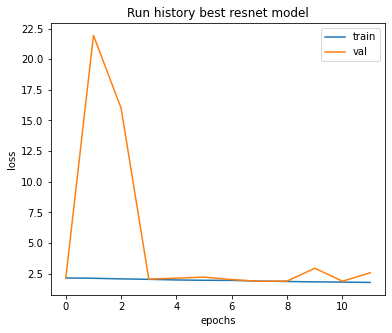

In [51]:
gr.plot_history(best_resnet_model_history, 'Run history best resnet model')

In [52]:
accuracy=df_conv_resnet_scores.loc[df_conv_resnet_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_conv_resnet_scores.loc[df_conv_resnet_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [53]:
score_dictionary['model'].append("Resnet based conv model")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [54]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.524796,0.528185
1,Naive bayes',0.554113,0.551830
2,Logistic regression,0.619384,0.613350
3,Random forest,0.596339,0.572950
4,Resnet based conv model,0.423498,0.418773


### Simple Convolutinal network

We will also implement a simpler convolutinal model. It includes three convolutional layers with a kernel of 5 with relu activation. The number of filters of convolutional layers are of size 32,128,64 respectively. Each convolutional layer is followed by a max-pooling layer with pool size 2 and a batch-normalization layer.  After the convolutional layers there are two dense layers with relu activation of size 128 and 64 units.  With a output layer of 10 units (For 10 genres) with softmax activation.

We will search for the best learning rate to apply

In [55]:
learning_rate=conf["hyperparams"]["conv_params"]["learning_rate"]
print(f"Different learning rate values we will check are: {learning_rate}")
print(f"Patience will be: {patience}")
print(f"Total limit on number of epochs will be: {epochs}")

Different learning rate values we will check are: [0.001, 0.003]
Patience will be: 3
Total limit on number of epochs will be: 20


The network configuration are the following: 

In [56]:
conv2d_config=conf["hyperparams"]["conv_params"]["simple_conv"]["conv_config"]
kernel_size=conf["hyperparams"]["conv_params"]["simple_conv"]["kernel"]
dense_config=conf["hyperparams"]["conv_params"]["simple_conv"]["dense_config"]
pool_size=conf["hyperparams"]["conv_params"]["simple_conv"]["pool"]

In [57]:
print(f"Convolutional number of units for each layer are: : {conv2d_config} units")
print(f"Kernel size will be: {kernel_size}")
print(f"Pool size of max-pooling layers will be: {pool_size}")
print(f"Dense layers at the end will be of units: : {dense_config}")

Convolutional number of units for each layer are: : [32, 128, 64] units
Kernel size will be: 5
Pool size of max-pooling layers will be: 2
Dense layers at the end will be of units: : [128, 64]


In [58]:
conv_gr.build_model(conv2d_config=conv2d_config, kernel_size=kernel_size, dense_config=dense_config, pool_size=pool_size)
print(conv_gr.model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     102528    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        2

In [59]:
#Dictinary to store results
simple_conv_scores={'learning rate':[], 'accuracy':[], 'f1-weighted':[]}

In [65]:
best_simple_conv_f1=math.inf
best_f1_simple_conv_history=None


#Search for the best learning rates.Each run trains the network and eveluates of the validation set.
#Results are loaded to a dictionary.
strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    for lr in learning_rate:
        conv_gr.build_model(conv2d_config=conv2d_config, kernel_size=kernel_size, dense_config=dense_config,pool_size=pool_size)
        print("\n")
        print(f"Start training simple convolutinal model. Learning rate:{lr}")
        history=conv_gr.fit_model(num_epochs=epochs, train_len=len_train, val_len=len_val, learning_rate=lr,patience=patience)
        conv_simple_history=history.history.copy()
        simple_conv_dict=conv_gr.evaluate('simple_conv', data_path,"images-val")
        simple_conv_scores['learning rate'].append(lr)
        simple_conv_scores['accuracy'].append(simple_conv_dict["accuracy"])
        simple_conv_scores['f1-weighted'].append(simple_conv_dict["f1_score"])
        accuracy=simple_conv_dict["accuracy"]
        f1_weighted=simple_conv_dict["f1_score"]
        print("*********************************************************")
        print(f"Finished training simple convolutinal model. Learning rate:{lr}, Accuracy:{ accuracy:.3f}, F1-weighted:{ f1_weighted:.3f}")
        print("*********************************************************")
        if  f1_weighted<best_simple_conv_f1:
            best_simple_conv_f1= f1_weighted
            best_simple_conv_model_history=conv_simple_history

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


Start training simple convolutinal model. Learning rate:0.001
Found 123399 images belonging to 10 classes.
Found 13712 images belonging to 10 classes.
0.001
Epoch 1/20
1929/1929 [==============================] - 167s 87ms/step - loss: 2.1331 - f1_score: 0.1945 - accuracy: 0.2337 - val_loss: 1.9824 - val_f1_score: 0.2185 - val_accuracy: 0.2818
Epoch 2/20
1929/1929 [==============================] - 166s 86ms/step - loss: 1.9551 - f1_score: 0.2387 - accuracy: 0.2924 - val_loss: 1.9584 - val_f1_score: 0.2377 - val_accuracy: 0.2883
Epoch 3/20
1929/1929 [==============================] - 166s 86ms/step - loss: 1.8403 - f1_score: 0.3132 - accuracy: 0.3508 - val_loss: 1.8992 - val_f1_score: 0.2864 - val_accuracy: 0.3322
Epoch 4/20
1929/1929 [==============================] - 166s 86ms/step - loss: 1.7049 - f1_score: 0.3683

In [61]:
df_simple_conv_scores= pd.DataFrame.from_dict(simple_conv_scores)
df_simple_conv_scores.head()

,learning rate,accuracy,f1-weighted
0,0.001,0.361654,0.347550
1,0.003,0.192532,0.062168


Let's look at the best model training history

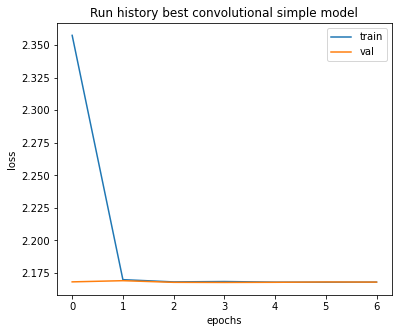

In [62]:
import goodreads as gr
gr.plot_history(best_simple_conv_model_history,'Run history best convolutional simple model')

We can see that the model didn't converge, validation loss keeps rising and val accuracy is low. Since also train results were not very high(0.65 accuracy), I do not believe it is overfitting but that the model is just not a good fit. (It was also difficult for human to know a book genre by cover..)

In [66]:
accuracy=df_simple_conv_scores.loc[df_simple_conv_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_simple_conv_scores.loc[df_simple_conv_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [67]:
score_dictionary['model'].append("Simple conv net")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [68]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head(10)

,model,accuracy,F1-weighted
0,Baseline,0.524796,0.528185
1,Naive bayes',0.554113,0.551830
2,Logistic regression,0.619384,0.613350
3,Random forest,0.596339,0.572950
4,Resnet based conv model,0.423498,0.418773
5,Simple conv net,0.361654,0.347550


### Neural network based on embeddings

Since our thinking is that the text features are potentially the best predictor of the genre we willuse another modeling approach.  (Mikolov et al. 2013) have showed that by using a skip-gram model (a model that when given a word, predicts the surrounding words) on a large corpus, wecan learn vector representations of words such that these representations will hold a ”meaning” ofthe word in the vector dimension. These vectors are known as an embedding. The spacy packageholds some versions of pre-trained embedding.   
We will use these pretrained embeddings (Trained on English corpora suitable for blogs and news with embeddingdimension being 300) as well as creating our own word2vec embeddings using gensim package.  We will first tokenise description and title features(very similar to the BOW method) and these word tokens will be replaced by the learned word embedding. In order toaddress a full sentence consecutive words meaning and not just each word separately we addeda convolutions layer of dimension 1 after the emebdding layers. Convoluinal 
layers are often usedin NLP for sequence representation and often give better results than RNN layers.

Another addition we have done is to use the embedding approach in order create a representation of an author.  Since our thinking is that an author is a very important feature in our model we willtransform each author to embeddings vector(initialized randomly with size of 10) and the networkwill learn the embedding representation of the author.A similar approach was used in collaborativefiltering applications by (He et al. 2017) to represent users and movies as embeddings. We will also add to the network the other numerical features we have.  
In total the network will be constructed from 4 different inputs (title,description,author and numerical features) , title, description and author will be transformed to embedding, description and title embeddings will be followed by a CNN withnumber of filters 64,16 respectively.  CNN will be followed by max pooling and dropout layer and.Before concatenation of all features a global average pooling layer is used.  the concatenatedoutput is followed by 2 dense layers of sizes 128 and 64 and the output layer is a 10 units softmax


In [69]:
tf.random.set_seed(SEED)

In [70]:
patience = conf["hyperparams"]["embedding_params"]["patience"]
epochs = conf["hyperparams"]["embedding_params"]["epochs"]
batch_size= conf["hyperparams"]["embedding_params"]["batch_size"]

In [71]:

print(f"Patience will be: {patience}")
print(f"Limit on number of epochs will be: {epochs}")
print(f"Batch size will be: {batch_size}")

Patience will be: 3
Limit on number of epochs will be: 20
Batch size will be: 32


### Hyperparameters search:

We will search for the following best hyperparameters:
- Learning rate
- Embedding type- Whether pretraind word embeddings on a large corpora from spacy model or our own trained word2vec embedding on our text features.
- Window/Kernel size for description-How many surrounding words to consider. this is relevant for both word2vec windows and also the kernel size of the convolutional nn on description.
- Window/Kernel size for titles-How many surrounding words to consider. this is relevant for both word2vec windows and also the kernel size of the convolutional nn on titles.

Other configuration were fixed(They were seacrhed but not included here full search). Listed later.

In [72]:
learning_rate = conf["hyperparams"]["embedding_params"]["learning_rate"]
print(f"Different learning rate values we will check are: {learning_rate}")
embedding_type = conf["hyperparams"]["embedding_params"]["embedding_type"]
print(f"Different embedding types we will check are: {embedding_type}")
kernel_size_desc = conf["hyperparams"]["embedding_params"]["kernel_desc"]
print(f"Kernel size for description we will check are: {kernel_size_desc}")
kernel_size_title = conf["hyperparams"]["embedding_params"]["kernel_title"]
print(f"Kernel size for title we will check are: {kernel_size_title}")
dropout_rates = conf["hyperparams"]["embedding_params"]["dropout_rates"]
print(f"Different dropout rates we will check are: {dropout_rates}")


Different learning rate values we will check are: [0.003, 0.001]
Different embedding types we will check are: ['spacy', 'word2vec']
Kernel size for description we will check are: [5, 10]
Kernel size for title we will check are: [3, 5]
Different dropout rates we will check are: [0.2, 0.1]


In [73]:
#Dictinary to store results

embedding_scores={'embedding type':[], 'learning rate':[], 'kernel_desc':[], 'kernel_title':[], 'dropout rate':[], 'accuracy':[], 'f1-weighted':[]}

will prepare again the data for inference. We will not need to add text features since we are going to analyse title and description features differently.


The train , val and test split is the same as before , it is just the further preparation that is different.

In [74]:
#We will prepare again the data for inference. We will not need to add text features since we are going to analyse title
#and description features differently.

#The train , val and test split is the same as before , it is just the further preparation that is different.
goodr_dataset_embeddings = gr.GoodreadsDataset.load_from_split(conf['preprocessed'], image_source_path, image_source_list, data_path)
goodr_dataset_embeddings.prepare_data_for_inference(add_text_features=False,drop_author_id=False,target_hot_encoding=True)
X_train=goodr_dataset_embeddings.X_train
y_train=goodr_dataset_embeddings.y_train
X_val=goodr_dataset_embeddings.X_val
y_val=goodr_dataset_embeddings.y_val

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples
All datasets prepared for inference


Other than Title , Description and Author features we will also input the other numerical features to the network.

In [75]:
column_names = list(goodr_dataset_embeddings.inference_col_names)
other_columns=[col for col in column_names if col not in ["description","title", "author_id"]]

In [76]:
other_columns

['num_pages',
 'publication_year',
 'is_ebook',
 'series',
 'read_count',
 'text_reviews_count',
 'ratings_count',
 'average_rating',
 'public_year_null',
 'num_pages_null',
 'authors_ratings_count',
 'author_average_rating']

In [77]:

num_classes= conf["num_classes"]
embedding_dim=conf["hyperparams"]["embedding_params"]["embedding_dim"]
num_voc_title = conf["hyperparams"]["embedding_params"]["title_max_voc"]
num_voc_description = conf["hyperparams"]["embedding_params"]["desc_max_voc"]
max_len_title = conf["hyperparams"]["embedding_params"]["title_max_len"]
max_len_desc = conf["hyperparams"]["embedding_params"]["desc_max_len"]
dense_config = conf["hyperparams"]["embedding_params"]["dense_config"]
conv_filters_desc = conf["hyperparams"]["embedding_params"]["conv_filters_desc"]
conv_filters_title = conf["hyperparams"]["embedding_params"]["conv_filters_title"]
window_size_desc = conf["hyperparams"]["embedding_params"]["word2vecwindow_desc"]
window_size_title = conf["hyperparams"]["embedding_params"]["word2vecwindow_title"]

print(f"Window size for description will be: {window_size_desc}")
print(f"Window size for title will be: {window_size_title}")
print(f"Embedding dimension will be: {embedding_dim}")
print(f"Vocabulary length for title will be: {num_voc_title}")
print(f"Vocabulary length for description will be: {num_voc_description}")
print(f"Maximum length for decription will be: {max_len_title}")
print(f"Maximum length for title will be: {max_len_desc}")
print(f"Number of filters for convolution on description will be: {conv_filters_desc}")
print(f"Number of filters for convolution on title will be: {conv_filters_title}")
print(f"Configuration of final dense layers will be: {dense_config}")

Window size for description will be: 10
Window size for title will be: 3
Embedding dimension will be: 300
Vocabulary length for title will be: 1000
Vocabulary length for description will be: 5000
Maximum length for decription will be: 10
Maximum length for title will be: 350
Number of filters for convolution on description will be: 64
Number of filters for convolution on title will be: 16
Configuration of final dense layers will be: [128, 64]


In [78]:
emb_gr = gr.EmbeddingNNGoodreads(batch_size=batch_size,
                                  num_classes=num_classes,
                                  embedding_dim=embedding_dim)

We first remove english stop words from title and description string

In [79]:
cleaned_train_title=np.array(emb_gr.remove_stopword(X_train["title"].values))
cleaned_val_title = np.array(emb_gr.remove_stopword(X_val["title"].values))
cleaned_train_description = np.array(emb_gr.remove_stopword(X_train["description"].values))
cleaned_val_description = np.array(emb_gr.remove_stopword(X_val["description"].values))

In [80]:
emb_gr.prepare_preprocessing_voc_layers(cleaned_train_title, num_voc_title=num_voc_title,
                                            description_array=cleaned_train_description,
                                            num_voc_description=num_voc_description,
                                            author_array=X_train["author_id"].values, max_len_title=max_len_title,
                                            max_len_desc=max_len_desc)

The model structure is the following (For specific hyperparmeters):

In [81]:
emb_gr.prepare_embedding_vectors(cleaned_train_description, cleaned_train_title,pretrained_emb='spacy',window_size_desc=window_size_desc,window_size_title=window_size_title)
emb_gr.build_model(len(other_columns), dense_config, kernel_size_desc=10, kernel_size_title=3, dropout_rate=0.1, conv_filters_desc=conv_filters_desc, conv_filters_title=conv_filters_title)
print(emb_gr.model.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
title_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Tokenizer_description (TextVect (None, 350)          0           desc_input[0][0]                 
__________________________________________________________________________________________________
Tokenizer_title (TextVectorizat (None, 10)           0           title_input[0][0]                
_______________________________________________________________________________________

Prepare tokenizer and embedding layers. We need to preprocess these layers in order to form a vocabulary in the training process. Embedding are either based on spacy pretrained emebddings vector or calculated word2vec embeddings on description and title features.

In [82]:
best_embedding_model_history=None
best_f1_embedding=math.inf


#Search for the best hyperparameters. Exhausted search(Cartesian product).Each run trains the network and eveluates of the validation set.
#Results are loaded to a dictionary.
strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    emb_gr.prepare_preprocessing_voc_layers(cleaned_train_title, num_voc_title=num_voc_title,
                                            description_array=cleaned_train_description,
                                            num_voc_description=num_voc_description,
                                            author_array=X_train["author_id"].values, max_len_title=max_len_title,
                                            max_len_desc=max_len_desc)
    for emb_type in embedding_type:
        emb_gr.prepare_embedding_vectors(cleaned_train_description, cleaned_train_title,pretrained_emb=emb_type,window_size_desc=window_size_desc,window_size_title=window_size_title)               
        for kernel_desc in kernel_size_desc:
            for kernel_title in kernel_size_title:                
                for lr in learning_rate:
                    for dropout_rate in dropout_rates:
                        emb_gr.build_model(len(other_columns), dense_config, kernel_size_desc=kernel_desc, kernel_size_title=kernel_title, dropout_rate=dropout_rate, conv_filters_desc=conv_filters_desc, conv_filters_title=conv_filters_title)
                        print("\n")
                        print(f"Start training model. Kernel description:{kernel_desc} ,Kernel title: {kernel_title}, Dropout rate:{dropout_rate}, Learning rate:{lr}, embedding type: {emb_type}")
                        
                        history=emb_gr.fit(X_train[other_columns].values, X_val[other_columns].values,  cleaned_train_description, 
                                           cleaned_val_description, cleaned_train_title, cleaned_val_title, 
                                           X_train["author_id"].values, X_val["author_id"].values, y_train, y_val, epochs,patience=patience, learning_rate = lr)
                        embedding_history=history.history.copy()
                        scores_dict=emb_gr.evaluate(X_val[other_columns].values, cleaned_val_description, cleaned_val_title, 
                                                    X_val["author_id"].values,y_val)
                        embedding_scores['embedding type'].append(emb_type)
                        embedding_scores['learning rate'].append(lr)
                        embedding_scores['kernel_desc'].append(kernel_desc)
                        embedding_scores['kernel_title'].append(kernel_title)
                        embedding_scores['dropout rate'].append(dropout_rate)
                        embedding_scores['accuracy'].append(scores_dict["accuracy"])
                        embedding_scores['f1-weighted'].append(scores_dict["f1_score"])
                        accuracy=scores_dict["accuracy"]
                        f1_weighted=scores_dict["f1_score"]
                        print("*********************************************************")
                        print(f"Finished training. Kernel description:{kernel_desc} ,Kernel title: {kernel_title}, Dropout rate:{dropout_rate}, Learning rate:{lr}, embedding type: {emb_type}, Accuracy:{accuracy:.3f}, F1-weighted:{f1_weighted:.3f}")
                        print("*********************************************************")
                        if  scores_dict["f1_score"]<best_f1_embedding:
                            best_f1_embedding= scores_dict["f1_score"]
                            best_embedding_model_history=embedding_history

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


Start training model. Kernel description:5 ,Kernel title: 3, Dropout rate:0.2, Learning rate:0.003, embedding type: spacy
Epoch 1/20
3857/3857 [==============================] - 27s 7ms/step - loss: 1.0773 - f1_score: 0.6367 - accuracy: 0.6478 - val_loss: 0.8596 - val_f1_score: 0.7236 - val_accuracy: 0.7290
Epoch 2/20
3857/3857 [==============================] - 25s 7ms/step - loss: 0.6621 - f1_score: 0.7921 - accuracy: 0.7947 - val_loss: 0.8541 - val_f1_score: 0.7299 - val_accuracy: 0.7285
Epoch 3/20
3857/3857 [==============================] - 25s 7ms/step - loss: 0.4400 - f1_score: 0.8646 - accuracy: 0.8654 - val_loss: 0.9390 - val_f1_score: 0.7382 - val_accuracy: 0.7347
Epoch 4/20
3857/3857 [==============================] - 25s 7ms/step - loss: 0.3572 - f1_score: 0.8889 - accuracy: 0.8892 - val_loss: 0.9703 - va

429/429 [==============================] - 1s 3ms/step - loss: 1.0392 - f1_score: 0.7377 - accuracy: 0.7337
*********************************************************
Finished training. Kernel description:5 ,Kernel title: 5, Dropout rate:0.1, Learning rate:0.003, embedding type: spacy, Accuracy:0.734, F1-weighted:0.738
*********************************************************


Start training model. Kernel description:5 ,Kernel title: 5, Dropout rate:0.2, Learning rate:0.001, embedding type: spacy
Epoch 1/20
3857/3857 [==============================] - 27s 7ms/step - loss: 1.0907 - f1_score: 0.6268 - accuracy: 0.6378 - val_loss: 0.8737 - val_f1_score: 0.7073 - val_accuracy: 0.7124
Epoch 2/20
3857/3857 [==============================] - 25s 6ms/step - loss: 0.6754 - f1_score: 0.7779 - accuracy: 0.7824 - val_loss: 0.8752 - val_f1_score: 0.7187 - val_accuracy: 0.7266
Epoch 3/20
3857/3857 [==============================] - 25s 6ms/step - loss: 0.4228 - f1_score: 0.8663 - accuracy: 0.8675 - 



Start training model. Kernel description:10 ,Kernel title: 5, Dropout rate:0.2, Learning rate:0.003, embedding type: spacy
Epoch 1/20
3857/3857 [==============================] - 29s 8ms/step - loss: 1.0752 - f1_score: 0.6372 - accuracy: 0.6488 - val_loss: 0.8844 - val_f1_score: 0.7129 - val_accuracy: 0.7195
Epoch 2/20
3857/3857 [==============================] - 27s 7ms/step - loss: 0.6581 - f1_score: 0.7939 - accuracy: 0.7965 - val_loss: 0.8640 - val_f1_score: 0.7285 - val_accuracy: 0.7270
Epoch 3/20
3857/3857 [==============================] - 27s 7ms/step - loss: 0.4383 - f1_score: 0.8676 - accuracy: 0.8682 - val_loss: 0.9590 - val_f1_score: 0.7319 - val_accuracy: 0.7241
Epoch 4/20
3857/3857 [==============================] - 27s 7ms/step - loss: 0.3507 - f1_score: 0.8917 - accuracy: 0.8920 - val_loss: 1.0218 - val_f1_score: 0.7337 - val_accuracy: 0.7300
Epoch 5/20
429/429 [==============================] - 1s 3ms/step - loss: 1.0592 - f1_score: 0.7308 - accuracy: 0.7218
********

429/429 [==============================] - 1s 3ms/step - loss: 1.0374 - f1_score: 0.7322 - accuracy: 0.7304
*********************************************************
Finished training. Kernel description:5 ,Kernel title: 3, Dropout rate:0.1, Learning rate:0.003, embedding type: word2vec, Accuracy:0.730, F1-weighted:0.732
*********************************************************


Start training model. Kernel description:5 ,Kernel title: 3, Dropout rate:0.2, Learning rate:0.001, embedding type: word2vec
Epoch 1/20
3857/3857 [==============================] - 27s 7ms/step - loss: 1.0976 - f1_score: 0.6255 - accuracy: 0.6362 - val_loss: 0.8598 - val_f1_score: 0.7194 - val_accuracy: 0.7222
Epoch 2/20
3857/3857 [==============================] - 25s 6ms/step - loss: 0.6937 - f1_score: 0.7748 - accuracy: 0.7787 - val_loss: 0.8554 - val_f1_score: 0.7289 - val_accuracy: 0.7256
Epoch 3/20
3857/3857 [==============================] - 25s 6ms/step - loss: 0.4444 - f1_score: 0.8602 - accuracy: 0.8

3857/3857 [==============================] - 24s 6ms/step - loss: 0.4157 - f1_score: 0.8698 - accuracy: 0.8704 - val_loss: 0.9321 - val_f1_score: 0.7328 - val_accuracy: 0.7321
Epoch 4/20
3857/3857 [==============================] - 24s 6ms/step - loss: 0.3185 - f1_score: 0.8982 - accuracy: 0.8984 - val_loss: 1.0080 - val_f1_score: 0.7347 - val_accuracy: 0.7329
Epoch 5/20
429/429 [==============================] - 1s 3ms/step - loss: 1.1495 - f1_score: 0.7271 - accuracy: 0.7251
*********************************************************
Finished training. Kernel description:5 ,Kernel title: 5, Dropout rate:0.1, Learning rate:0.001, embedding type: word2vec, Accuracy:0.725, F1-weighted:0.727
*********************************************************


Start training model. Kernel description:10 ,Kernel title: 3, Dropout rate:0.2, Learning rate:0.003, embedding type: word2vec
Epoch 1/20
3857/3857 [==============================] - 27s 7ms/step - loss: 1.0660 - f1_score: 0.6406 - accuracy: 0.

Epoch 1/20
3857/3857 [==============================] - 28s 7ms/step - loss: 1.0497 - f1_score: 0.6449 - accuracy: 0.6548 - val_loss: 0.9052 - val_f1_score: 0.7101 - val_accuracy: 0.7100
Epoch 2/20
3857/3857 [==============================] - 26s 7ms/step - loss: 0.6282 - f1_score: 0.8033 - accuracy: 0.8054 - val_loss: 0.8596 - val_f1_score: 0.7319 - val_accuracy: 0.7292
Epoch 3/20
3857/3857 [==============================] - 26s 7ms/step - loss: 0.4076 - f1_score: 0.8746 - accuracy: 0.8750 - val_loss: 0.9466 - val_f1_score: 0.7315 - val_accuracy: 0.7254
Epoch 4/20
3857/3857 [==============================] - 26s 7ms/step - loss: 0.3289 - f1_score: 0.8961 - accuracy: 0.8964 - val_loss: 1.0028 - val_f1_score: 0.7349 - val_accuracy: 0.7275
Epoch 5/20
429/429 [==============================] - 1s 3ms/step - loss: 0.9787 - f1_score: 0.7418 - accuracy: 0.7353
*********************************************************
Finished training. Kernel description:10 ,Kernel title: 5, Dropout rate:0.1

In [83]:
df_embedding_scores= pd.DataFrame.from_dict(embedding_scores)
df_embedding_scores.head(40)

,embedding type,learning rate,kernel_desc,kernel_title,dropout rate,accuracy,f1-weighted
0,spacy,0.003,5,3,0.2,0.723964,0.735680
1,spacy,0.003,5,3,0.1,0.727173,0.732391
2,spacy,0.001,5,3,0.2,0.725788,0.733741
3,spacy,0.001,5,3,0.1,0.730601,0.735412
4,spacy,0.003,5,5,0.2,0.740446,0.737112
5,spacy,0.003,5,5,0.1,0.733737,0.737657
6,spacy,0.001,5,5,0.2,0.728997,0.723071
7,spacy,0.001,5,5,0.1,0.739571,0.732602
8,spacy,0.003,10,3,0.2,0.723381,0.716037
9,spacy,0.003,10,3,0.1,0.732716,0.728849


We can see that the best model was based on word2vec our own trained embeddings with dropout 0.1 and learning rate of 0.003 and Description kernel of 10 and title kernel of 5

In [84]:
accuracy=df_embedding_scores.loc[df_embedding_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_embedding_scores.loc[df_embedding_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [85]:
score_dictionary['model'].append("Embedding model")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

### All models best validation results

In [86]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head(10)

,model,accuracy,F1-weighted
0,Baseline,0.524796,0.528185
1,Naive bayes',0.554113,0.551830
2,Logistic regression,0.619384,0.613350
3,Random forest,0.596339,0.572950
4,Resnet based conv model,0.423498,0.418773
5,Simple conv net,0.361654,0.347550
6,Embedding model,0.735268,0.741778


In [87]:
df_scores=df_scores.set_index('model')

Text(0.5, 0, 'Rate %')

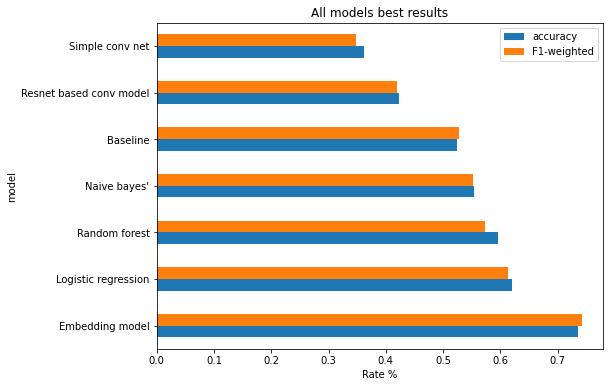

In [88]:
figure, axes = plt.subplots(figsize=(8, 6))
df_scores[["accuracy","F1-weighted"]].sort_values(["F1-weighted"], ascending=False).plot(kind='barh',ax=axes)
axes.set_title('All models best results')
axes.set_xlabel("Rate %")

 The embedding model was by far the best model and achieved 0.75% accuracy score.Our own data trained word2vec embedding were better than loaded embedding which is not surprising because it is fitted to our data. A large kernel size of 10 for description data was best-probably because catching a more surrounding words injects more "meaning", title kernel also was large with best result of 5 kernel size.Dropout rate was best at 0.1 and learning rate with 0.003.

## Final Results

We will compare our best model on test data against baseline on test data

In [93]:
test_scores={'Model':[], 'accuracy':[], 'f1-weighted':[]}

### Baseline test

In [94]:
base_dataset = gr.GoodreadsDataset.load_from_split(conf['preprocessed'], image_source_path, image_source_list, data_path)

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples


Baseline classifer
Accuracy: 0.527
                                        precision    recall  f1-score   support

                                poetry       0.67      0.29      0.40       507
                              children       0.73      0.47      0.57       869
                   fantasy, paranormal       0.32      0.80      0.46      2934
history, historical fiction, biography       0.62      0.39      0.48      2133
                       comics, graphic       0.90      0.76      0.82      1151
                           non-fiction       0.63      0.25      0.36      1714
              mystery, thriller, crime       0.76      0.56      0.65      2180
                           young-adult       0.58      0.39      0.46       770
                               romance       0.78      0.60      0.68      2237
                               fiction       0.35      0.16      0.22       740

                              accuracy                           0.53     15235
   

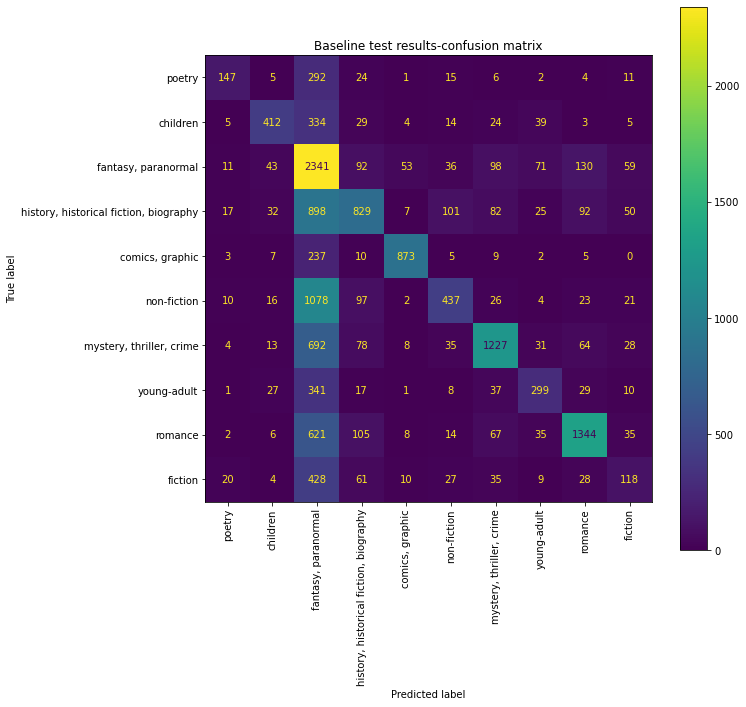

In [95]:
#There is no need for validation dataset(becuase there is no real training..) 
#so we will unite the train and validation dataset in order the have a larger dataset.
full_generes=conf["preprocessed"]["full_genres_col"]
X_train_val=np.vstack((base_dataset.X_train,base_dataset.X_val))
y_train_val = np.vstack((base_dataset.y_train, base_dataset.y_val))

X_test=base_dataset.X_test
y_test=base_dataset.y_test

#create the baseline model and predict test genres
baseline_learner=gr.Baseline(conf["preprocessed"]["preprocess_col_order"])
baseline_learner.fit(X_train_val,y_train_val)
y_test_predicted=baseline_learner.predict(base_dataset.X_test)

#calculate score on test data
accuracy=accuracy_score(y_test, y_test_predicted)
f1_weighted=f1_score(y_test, y_test_predicted, average='weighted')
test_scores['Model'].append("Baseline model")
test_scores['accuracy'].append(accuracy)
test_scores['f1-weighted'].append(f1_weighted)

gr.report_result(y_test_predicted,y_test,'Baseline',full_generes,'Baseline test results-confusion matrix')

###  Best model- test results

Assumes you have run the embedding model and the dataset is prepared.

In [96]:
#Best hyperparameters of the embedding model
kernel_desc=10
kernel_title=5
lr=0.003
dropout_rate=0.1
emb_type='word2vec'

#conctenate train and validation datasets
cleaned_X_train_val_title=np.vstack((cleaned_train_title[:, np.newaxis],cleaned_val_title[:, np.newaxis]))
cleaned_X_train_val_description=np.vstack((cleaned_train_description[:, np.newaxis],cleaned_val_description[:, np.newaxis]))

cleaned_X_train_val_title=np.squeeze(cleaned_X_train_val_title)
cleaned_X_train_val_description=np.squeeze(cleaned_X_train_val_description)

print(cleaned_X_train_val_title.shape)
y_train_val=np.vstack((goodr_dataset_embeddings.y_train,goodr_dataset_embeddings.y_val))
X_train_val=pd.concat([goodr_dataset_embeddings.X_train,goodr_dataset_embeddings.X_val])

#prepare test
print(X_train_val.shape)
y_test=goodr_dataset_embeddings.y_test
X_test=goodr_dataset_embeddings.X_test
cleaned_test_title = np.array(emb_gr.remove_stopword(X_test["title"].values))
cleaned_test_description = np.array(emb_gr.remove_stopword(X_test["description"].values))



#prepare voc-now based on train+validation data
emb_gr.prepare_preprocessing_voc_layers(cleaned_X_train_val_title, num_voc_title=num_voc_title,
                                            description_array=cleaned_X_train_val_description,
                                            num_voc_description=num_voc_description,
                                            author_array=X_train_val["author_id"].values, max_len_title=max_len_title,
                                            max_len_desc=max_len_desc)
emb_gr.build_model(len(other_columns), dense_config, kernel_size_desc=kernel_desc, kernel_size_title=kernel_title, dropout_rate=dropout_rate, conv_filters_desc=conv_filters_desc, conv_filters_title=conv_filters_title)
print("\n")
print(f"Start training.Kernel description:{kernel_desc} ,Kernel title: {kernel_title}, Dropout rate:{dropout_rate}, Learning rate:{lr}, embedding type: {emb_type}")

#trainign of the model
history=emb_gr.fit(X_train_val[other_columns].values, X_test[other_columns].values,  cleaned_X_train_val_description, 
                                           cleaned_test_description, cleaned_X_train_val_title, cleaned_test_title, 
                                           X_train_val["author_id"].values, X_test["author_id"].values, y_train_val, y_test, epochs,patience=patience, learning_rate = lr)
embedding_history=history.history.copy()

#Evaluate test results
scores_dict=emb_gr.evaluate(X_test[other_columns].values, cleaned_test_description, cleaned_test_title, 
                                                    X_test["author_id"].values,y_test)




(137111,)
(137111, 15)


Start training.Kernel description:10 ,Kernel title: 5, Dropout rate:0.1, Learning rate:0.003, embedding type: word2vec
Epoch 1/20
4285/4285 [==============================] - 58s 13ms/step - loss: 1.0948 - f1_score: 0.6303 - accuracy: 0.6419 - val_loss: 0.8997 - val_f1_score: 0.7008 - val_accuracy: 0.7104
Epoch 2/20
4285/4285 [==============================] - 57s 13ms/step - loss: 0.5896 - f1_score: 0.8159 - accuracy: 0.8183 - val_loss: 0.8741 - val_f1_score: 0.7275 - val_accuracy: 0.7286
Epoch 3/20
4285/4285 [==============================] - 56s 13ms/step - loss: 0.3717 - f1_score: 0.8846 - accuracy: 0.8849 - val_loss: 0.9315 - val_f1_score: 0.7299 - val_accuracy: 0.7285
Epoch 4/20
4285/4285 [==============================] - 57s 13ms/step - loss: 0.2878 - f1_score: 0.9086 - accuracy: 0.9088 - val_loss: 1.0149 - val_f1_score: 0.7285 - val_accuracy: 0.7252
Epoch 5/20
477/477 [==============================] - 2s 4ms/step - loss: 1.0600 - f1_score: 0.7264 - ac

In [97]:
y_test_predicted=emb_gr.predict(X_test[other_columns].values, cleaned_test_description, cleaned_test_title, 
                                                    X_test["author_id"].values)


In [98]:
labels=goodr_dataset_embeddings.label_classes
predicted=[labels[ind] for ind in tf.argmax(y_test_predicted,1).numpy()]
true=[labels[ind] for ind in tf.argmax(y_test,1).numpy()]

Embedding model classifer
Accuracy: 0.728
                                        precision    recall  f1-score   support

                              children       0.68      0.78      0.73       869
                       comics, graphic       0.89      0.86      0.87      1151
                   fantasy, paranormal       0.75      0.80      0.77      2934
                               fiction       0.34      0.30      0.32       740
history, historical fiction, biography       0.73      0.61      0.66      2133
              mystery, thriller, crime       0.80      0.76      0.78      2180
                           non-fiction       0.64      0.82      0.72      1714
                                poetry       0.79      0.75      0.77       507
                               romance       0.82      0.75      0.79      2237
                           young-adult       0.58      0.57      0.57       770

                              accuracy                           0.73     15

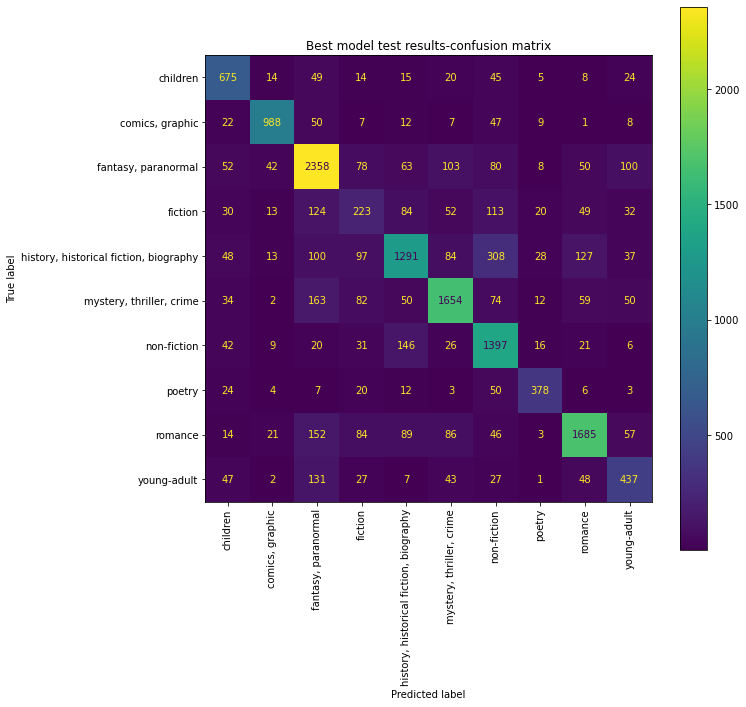

In [99]:

accuracy=accuracy_score(true, predicted)
f1_weighted=f1_score(true, predicted, average='weighted')
test_scores['Model'].append("Embedding model")
test_scores['accuracy'].append(accuracy)
test_scores['f1-weighted'].append(f1_weighted)



gr.report_result(predicted,true,'Embedding model',labels=labels,title='Best model test results-confusion matrix')

In [107]:
#emb_gr.save_model(conf["files"]["data_dir"],'best_model_embeddings')

### Comparison of test results

In [101]:
df_test_scores= pd.DataFrame.from_dict(test_scores)
df_test_scores.head(10)

,Model,accuracy,f1-weighted
0,Baseline model,0.526879,0.531064
1,Embedding model,0.727667,0.726356


Text(0.5, 0, 'Rate %')

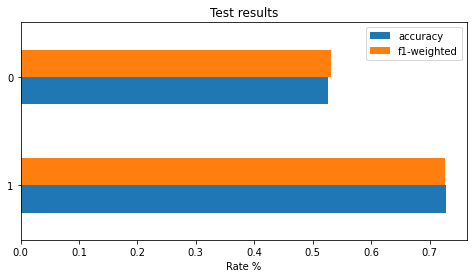

In [102]:
#df_test_scores=df_test_scores.set_index('Model')
figure, axes = plt.subplots(figsize=(8, 4))
df_test_scores[["accuracy","f1-weighted"]].sort_values(["f1-weighted"], ascending=False).plot(kind='barh',ax=axes)
axes.set_title('Test results')
axes.set_xlabel("Rate %")

We can see that test results were very similar to validation results. From the confusion matrix we can see the the best results were achieved in "fantasy, paranormal" category followed by mystery and romance categories. This is easy to understand since these categories have very distinctive text features. To conclude we can see that the best results were achieved by using the text features as embedding with a neural network, this is easy to understand result since also humans can categorise a text to genre easier than doing it by looking at the book covers.
Should we had more time I would have explored other network configuration with embedding and also trained further the word2vec embeddings themselves. I would also try to collect more data in order to achieve better generalization.

We can see some similarities of words in our vocabulary

In [104]:
emb_gr.description_word2vec_model.wv.most_similar(positive=["mystery"])

[('mysteries', 0.7404965162277222),
 ('puzzle', 0.5181804895401001),
 ('riddle', 0.5103638172149658),
 ('conspiracy', 0.39919593930244446),
 ('clues', 0.39266592264175415),
 ('plot', 0.37901729345321655),
 ('case', 0.37475165724754333),
 ('intrigue', 0.3703572154045105),
 ('puzzles', 0.36437758803367615),
 ('riddles', 0.3559808135032654)]

In [105]:
emb_gr.description_word2vec_model.wv.most_similar(positive=["magic"])

[('magical', 0.6456886529922485),
 ('magick', 0.5331777930259705),
 ('witches', 0.48658937215805054),
 ('witch', 0.47864097356796265),
 ('powers', 0.47777286171913147),
 ('dragons', 0.4648091793060303),
 ('sorceress', 0.44352540373802185),
 ('sorcery', 0.43915215134620667),
 ('sorcerer', 0.4367944002151489),
 ('wizard', 0.43458840250968933)]

In [106]:
emb_gr.description_word2vec_model.wv.most_similar(positive=["love"])

[('friendship', 0.5420276522636414),
 ('passion', 0.5278884172439575),
 ('desire', 0.4990245997905731),
 ('happiness', 0.46971020102500916),
 ('forgiveness', 0.46797144412994385),
 ('romance', 0.4674749970436096),
 ('heartbreak', 0.4531122148036957),
 ('heartache', 0.45131760835647583),
 ('loves', 0.4244123697280884),
 ('relationship', 0.41323718428611755)]